# ** 607 Final Project**
## CUNY MSDS Rose Koh

---


### ** Cryptocurrency: Bitcoin price prediction -- Analysis between BTC vs USD and Gold vs USD prices to forecast **


### May 12th, 2018

---

### ** << Contents >> **

**1. Data acquisition**

    * web page scraping (API)
    * .csv

**2. Data preprocessing**

    * timestamp conversion, indexing
    * subset, merge, change type, clean data
    * missing value management - NA check, forward fill
    * feature engineering: date, rate of change, dummies
    * transformation wide to long format - using unstack()

**3. Data Analysis**

    * Distribution
    * EDA
    * Marketcap
    * Volatility
    * Correlation
    * Distribution

    * Split data
    * Normalization
    * Scorer - rmse, rmsle
    
    - OLS(ordinary least squares) Regression
         - Backwards elimination
    - Linear regression model
    - Regularization models - Ridge, Lasso
    - Ensemble models - Random forest, Gradient boosting regression
    - XGboost

**4. Conclusion**

---

## 1. Data acquisition

In [1]:
# Load modules

import numpy as np
import pandas as pd
from datetime import datetime
import json
from bs4 import BeautifulSoup
import requests
import io
import missingno as msno
from scipy import stats

import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
style.use('fivethirtyeight')
%matplotlib inline 

import datetime as dt

from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import make_scorer
from sklearn.cross_validation import cross_val_score

from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import warnings
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb

/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# Load data

# webscraping daily bitcoin data 

def get_btc(ticker):

    cols = ['date', 'timestamp', 'close', 'volumeto']
    lst = ['time', 'close', 'volumeto']

    timetoday = datetime.today().timestamp()
    current_time = timetoday
    limit = 1800
    
    for j in range(2):
        df = pd.DataFrame(columns=cols)
        url = "https://min-api.cryptocompare.com/data/histoday?fsym=" + ticker + "&tsym=USD" + "&toTs=" + str(
            int(current_time)) + "&limit=" + str(limit)
        response = requests.get(url)
        soup = BeautifulSoup(response.content, "html.parser")
        dic = json.loads(soup.prettify())
        data = pd.DataFrame(dic['Data'])
        data.time = pd.to_datetime(data.time, unit='s')
    return data

# get cryptocurrency volume data

def get_volume():
    cols = ['date', 'timestamp', 'volume']
    lst = ['time', 'volume']
    
    timetoday = datetime.today().timestamp()
    current_time = timetoday
    limit = 1800
    
    for j in range(2):
        df = pd.DataFrame(columns = cols)
        url = "https://min-api.cryptocompare.com/data/exchange/histoday?tsym=USD&limit=" + str(limit)
        response = requests.get(url)
        soup = BeautifulSoup(response.content, "html.parser")
        dic = json.loads(soup.prettify())
        data = pd.DataFrame(dic['Data'])
        data.time = pd.to_datetime(data.time, unit='s')
    return data

In [3]:
# get crypto historical data
btc = get_btc('BTC')
volume = get_volume()

In [4]:
print(btc.shape)
btc.tail()

(1801, 7)


,close,high,low,open,time,volumefrom,volumeto
1796,9196.13,9472.09,9063.07,9377.08,2018-05-08,72659.12,6.739241e+08
1797,9321.16,9373.46,8987.27,9196.13,2018-05-09,67939.11,6.254951e+08
1798,9032.22,9393.95,9017.13,9321.52,2018-05-10,67915.99,6.298506e+08
1799,8421.00,9032.27,8363.50,9032.22,2018-05-11,134727.27,1.176889e+09
1800,8259.12,8487.68,8225.97,8420.82,2018-05-12,37355.48,3.136649e+08


In [5]:
print(volume.shape)
volume.tail()

(1801, 2)


,time,volume
1796,2018-05-08,9.798917e+09
1797,2018-05-09,9.640220e+09
1798,2018-05-10,9.304789e+09
1799,2018-05-11,1.310261e+10
1800,2018-05-12,4.218503e+09


In [6]:
# merge
crypto_data = pd.merge(btc, volume, left_on = 'time', right_on = 'time', how = 'left')

# check data
print(crypto_data.shape)
crypto_data.tail()

(1801, 8)


,close,high,low,open,time,volumefrom,volumeto,volume
1796,9196.13,9472.09,9063.07,9377.08,2018-05-08,72659.12,6.739241e+08,9.798917e+09
1797,9321.16,9373.46,8987.27,9196.13,2018-05-09,67939.11,6.254951e+08,9.640220e+09
1798,9032.22,9393.95,9017.13,9321.52,2018-05-10,67915.99,6.298506e+08,9.304789e+09
1799,8421.00,9032.27,8363.50,9032.22,2018-05-11,134727.27,1.176889e+09,1.310261e+10
1800,8259.12,8487.68,8225.97,8420.82,2018-05-12,37355.48,3.136649e+08,4.218503e+09


In [7]:
crypto_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1801 entries, 0 to 1800
Data columns (total 8 columns):
close         1801 non-null float64
high          1801 non-null float64
low           1801 non-null float64
open          1801 non-null float64
time          1801 non-null datetime64[ns]
volumefrom    1801 non-null float64
volumeto      1801 non-null float64
volume        1801 non-null float64
dtypes: datetime64[ns](1), float64(7)
memory usage: 126.6 KB


In [8]:
# get daily gold data reading .csv
gold_df = pd.read_csv("data/gold_edit.csv", parse_dates = ["Date"])

# gold data structure
gold_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3513 entries, 0 to 3512
Data columns (total 12 columns):
Date                                                                             3513 non-null datetime64[ns]
 GLD Close                                                                       3513 non-null object
 LBMA Gold Price                                                                 3513 non-null object
 NAV per GLD in Gold                                                             3513 non-null object
 NAV/share at 10.30 a.m. NYT                                                     3513 non-null object
 Indicative Price of GLD at 4.15 p.m. NYT                                        3513 non-null object
 Mid point of bid/ask spread at 4.15 p.m. NYT#                                   3513 non-null object
 Premium/Discount of GLD mid point v Indicative Value of GLD at 4.15 p.m. NYT    3513 non-null object
 Daily Share Volume                                                  

---

## 2. Data preprocessing

In [9]:
# subset gold data
gold_df = gold_df[['Date',' GLD Close',' LBMA Gold Price', ' Total Net Asset Value in the Trust']]
gold_df.columns = ['Date','gold_close', 'lbma_gold_price', 'gold_volume']

# check data
print(gold_df.shape)
gold_df.head()

(3513, 4)


,Date,gold_close,lbma_gold_price,gold_volume
0,2004-11-18,44.38,442.00,114920000.00
1,2004-11-19,44.78,445.60,828806907.20
2,2004-11-22,44.75,447.80,1253785205.50
3,2004-11-23,45.05,448.15,1254751438.19
4,2004-11-24,45.05,448.60,1390568824.08


In [10]:
gold_df.tail()

,Date,gold_close,lbma_gold_price,gold_volume
3508,2018-05-02,123.65,1304.20,36332029734.61
3509,2018-05-03,124.28,1315.05,36584133124.96
3510,2018-05-04,124.54,1309.40,36376851637.92
3511,2018-05-07,124.57,1309.40,36375655699.74
3512,2018-05-08,124.59,1306.60,36297466816.42


In [11]:
# Merge BTC + GOLD

origin_data = pd.merge(crypto_data, gold_df, left_on = 'time', right_on = 'Date', how = 'left')
data = origin_data
print(data.shape)
data.head(30)

(1801, 12)


,close,high,low,open,time,volumefrom,volumeto,volume,Date,gold_close,lbma_gold_price,gold_volume
0,111.00,119.13,106.15,118.97,2013-06-07,65767.53,7372031.58,51664.95,2013-06-07,133.28,1386.00,44855561784.28
1,107.89,113.19,107.00,111.00,2013-06-08,17218.19,1874098.59,30641.84,NaT,NaN,NaN,NaN
2,100.44,108.99,88.00,107.89,2013-06-09,149431.84,14647793.51,45316.52,NaT,NaN,NaN,NaN
3,106.35,110.63,95.00,100.44,2013-06-10,64320.02,6786321.13,56151.74,2013-06-10,133.96,1383.25,44885377597.31
4,109.00,109.60,103.23,106.35,2013-06-11,16131.56,1727992.79,72795.65,2013-06-11,133.25,1374.25,44592680689.74
5,108.78,112.25,106.00,109.00,2013-06-12,17700.09,1934487.77,44171.21,2013-06-12,134.25,1382.75,44868163404.02
6,103.95,110.30,100.30,108.78,2013-06-13,30435.38,3204375.98,76030.07,2013-06-13,133.74,1385.00,44659592431.27
7,100.00,104.70,97.10,103.95,2013-06-14,36054.00,3629511.97,48395.00,2013-06-14,134.43,1391.25,44860754533.37
8,99.80,103.70,97.50,100.00,2013-06-15,22532.25,2264105.80,25436.03,NaT,NaN,NaN,NaN
9,99.90,101.75,98.90,99.80,2013-06-16,8654.91,865174.26,20223.76,NaT,NaN,NaN,NaN


In [12]:
data.tail(30)

,close,high,low,open,time,volumefrom,volumeto,volume,Date,gold_close,lbma_gold_price,gold_volume
1771,7899.11,8237.16,7758.80,7927.73,2018-04-13,145665.26,1.171436e+09,9.819940e+09,2018-04-13,127.45,1343.70,37402299832.24
1772,8022.51,8195.34,7841.19,7898.74,2018-04-14,66678.63,5.372864e+08,6.349903e+09,NaT,NaN,NaN,NaN
1773,8376.73,8437.03,8021.04,8022.51,2018-04-15,68822.07,5.705278e+08,6.267143e+09,NaT,NaN,NaN,NaN
1774,8079.77,8430.93,7929.24,8376.73,2018-04-16,87681.75,7.134720e+08,6.876921e+09,2018-04-16,127.63,1349.35,37558359929.68
1775,7921.63,8187.60,7858.12,8079.77,2018-04-17,71933.60,5.808805e+08,7.151818e+09,2018-04-17,127.75,1342.10,37356116352.91
1776,8189.96,8246.57,7908.92,7921.65,2018-04-18,73050.12,5.935008e+08,6.983644e+09,2018-04-18,127.85,1351.45,37616000625.60
1777,8301.82,8321.01,8136.42,8189.92,2018-04-19,72820.98,6.020990e+08,7.634949e+09,2018-04-19,127.60,1348.60,37536247548.80
1778,8877.08,8945.14,8243.49,8301.82,2018-04-20,114730.74,9.799949e+08,1.127918e+10,2018-04-20,126.63,1336.75,37205945303.99
1779,8935.72,9047.82,8631.18,8877.15,2018-04-21,93635.24,8.290734e+08,1.138542e+10,NaT,NaN,NaN,NaN
1780,8823.36,9043.98,8788.44,8935.85,2018-04-22,68212.83,6.101831e+08,9.521442e+09,NaT,NaN,NaN,NaN


The Gold data shows NaN on weekends as the trade close. 

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1801 entries, 0 to 1800
Data columns (total 12 columns):
close              1801 non-null float64
high               1801 non-null float64
low                1801 non-null float64
open               1801 non-null float64
time               1801 non-null datetime64[ns]
volumefrom         1801 non-null float64
volumeto           1801 non-null float64
volume             1801 non-null float64
Date               1282 non-null datetime64[ns]
gold_close         1282 non-null object
lbma_gold_price    1282 non-null object
gold_volume        1282 non-null object
dtypes: datetime64[ns](2), float64(7), object(3)
memory usage: 182.9+ KB


In [14]:
# subset and column name change
data = data[['time','close', 'volumeto', 'volume', 'gold_close', 'lbma_gold_price', 'gold_volume']]
data.columns = ['date', 'btc_close', 'btc_volume', 'crypto_volume', 'gold_close', 'lbma_gold', 'gold_volume']
data.tail(30)

# Index date if required
#data.set_index('date', inplace=True)

,date,btc_close,btc_volume,crypto_volume,gold_close,lbma_gold,gold_volume
1771,2018-04-13,7899.11,1.171436e+09,9.819940e+09,127.45,1343.70,37402299832.24
1772,2018-04-14,8022.51,5.372864e+08,6.349903e+09,NaN,NaN,NaN
1773,2018-04-15,8376.73,5.705278e+08,6.267143e+09,NaN,NaN,NaN
1774,2018-04-16,8079.77,7.134720e+08,6.876921e+09,127.63,1349.35,37558359929.68
1775,2018-04-17,7921.63,5.808805e+08,7.151818e+09,127.75,1342.10,37356116352.91
1776,2018-04-18,8189.96,5.935008e+08,6.983644e+09,127.85,1351.45,37616000625.60
1777,2018-04-19,8301.82,6.020990e+08,7.634949e+09,127.60,1348.60,37536247548.80
1778,2018-04-20,8877.08,9.799949e+08,1.127918e+10,126.63,1336.75,37205945303.99
1779,2018-04-21,8935.72,8.290734e+08,1.138542e+10,NaN,NaN,NaN
1780,2018-04-22,8823.36,6.101831e+08,9.521442e+09,NaN,NaN,NaN


In [15]:
# NA check
# check NA
data.isnull().any()

date             False
btc_close        False
btc_volume       False
crypto_volume    False
gold_close        True
lbma_gold         True
gold_volume       True
dtype: bool

In [16]:
data[data["gold_close"].isnull()]
data[data["lbma_gold"].isnull()]
data[data["gold_volume"].isnull()]

,date,btc_close,btc_volume,crypto_volume,gold_close,lbma_gold,gold_volume
1,2013-06-08,107.89,1.874099e+06,3.064184e+04,NaN,NaN,NaN
2,2013-06-09,100.44,1.464779e+07,4.531652e+04,NaN,NaN,NaN
8,2013-06-15,99.80,2.264106e+06,2.543603e+04,NaN,NaN,NaN
9,2013-06-16,99.90,8.651743e+05,2.022376e+04,NaN,NaN,NaN
15,2013-06-22,108.20,7.911574e+05,1.056660e+05,NaN,NaN,NaN
16,2013-06-23,107.90,1.188749e+06,8.212053e+04,NaN,NaN,NaN
22,2013-06-29,95.00,2.469705e+06,6.440810e+04,NaN,NaN,NaN
23,2013-06-30,97.51,8.317210e+05,7.597297e+04,NaN,NaN,NaN
29,2013-07-06,69.66,2.885730e+06,9.740070e+04,NaN,NaN,NaN
30,2013-07-07,76.50,3.040545e+06,7.781810e+04,NaN,NaN,NaN


Gold fills " Holidays" on holidays as string the entire row. Cryptocurrency trades 24/7 while gold closes on weekends and holidays, while the trade is closed, there is no differences in the price, thus we use forward-fill to fill the NA values.

In [17]:
data = data.fillna(method='ffill')
# change the ' HOLIDAY' to NA
# fill in NA, gold holiday = closing of the day before
data.replace(' HOLIDAY', np.NaN, inplace = True)
data = data.fillna(method='ffill')

In [18]:
data.isnull().any()
data.tail(30)

,date,btc_close,btc_volume,crypto_volume,gold_close,lbma_gold,gold_volume
1771,2018-04-13,7899.11,1.171436e+09,9.819940e+09,127.45,1343.70,37402299832.24
1772,2018-04-14,8022.51,5.372864e+08,6.349903e+09,127.45,1343.70,37402299832.24
1773,2018-04-15,8376.73,5.705278e+08,6.267143e+09,127.45,1343.70,37402299832.24
1774,2018-04-16,8079.77,7.134720e+08,6.876921e+09,127.63,1349.35,37558359929.68
1775,2018-04-17,7921.63,5.808805e+08,7.151818e+09,127.75,1342.10,37356116352.91
1776,2018-04-18,8189.96,5.935008e+08,6.983644e+09,127.85,1351.45,37616000625.60
1777,2018-04-19,8301.82,6.020990e+08,7.634949e+09,127.60,1348.60,37536247548.80
1778,2018-04-20,8877.08,9.799949e+08,1.127918e+10,126.63,1336.75,37205945303.99
1779,2018-04-21,8935.72,8.290734e+08,1.138542e+10,126.63,1336.75,37205945303.99
1780,2018-04-22,8823.36,6.101831e+08,9.521442e+09,126.63,1336.75,37205945303.99


In [19]:
# change gold value type into float
data.gold_close = data.gold_close.astype(float)
data.lbma_gold = data.lbma_gold.astype(float)
data.gold_volume = data.gold_volume.astype(float)

In [20]:
# data summary
print(data.shape)
print(data.info())
print(data.dtypes)

(1801, 7)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1801 entries, 0 to 1800
Data columns (total 7 columns):
date             1801 non-null datetime64[ns]
btc_close        1801 non-null float64
btc_volume       1801 non-null float64
crypto_volume    1801 non-null float64
gold_close       1801 non-null float64
lbma_gold        1801 non-null float64
gold_volume      1801 non-null float64
dtypes: datetime64[ns](1), float64(6)
memory usage: 112.6 KB
None
date             datetime64[ns]
btc_close               float64
btc_volume              float64
crypto_volume           float64
gold_close              float64
lbma_gold               float64
gold_volume             float64
dtype: object


---

### Feature engineering

In [21]:
# parse date into year, month, week, day, dayofweek
data["year"] = data["date"].dt.year
data['month'] = data['date'].dt.month
data['week'] = data['date'].dt.week
data['day'] = data['date'].dt.day
data['dayofweek'] = data['date'].dt.dayofweek

In [22]:
# rate of change
data["btc_close_roc"] = np.gradient(data['btc_close'])
data["btc_volume_roc"] = np.gradient(data['btc_volume'])
data["crypto_volume_roc"] = np.gradient(data['crypto_volume'])
data["gold_close_roc"] = np.gradient(data['gold_close'])
data["lbma_gold_roc"] = np.gradient(data['lbma_gold'])
data["gold_volume_roc"] = np.gradient(data['gold_volume'])

In [23]:
# Since date data is numeric value, which will confuse the regression model, we create dummies.
# dayofweek
dayofweek_dummies = pd.get_dummies(data['dayofweek'], prefix = 'dayofweek')
print(dayofweek_dummies.shape)
dayofweek_dummies.head()
data = pd.concat([data, dayofweek_dummies], axis=1)

# year
year_dummies = pd.get_dummies(data['year'], prefix = 'year')
print(year_dummies.shape)
data = pd.concat([data, year_dummies], axis=1)

# month
month_dummies = pd.get_dummies(data['month'], prefix = 'month')
print(month_dummies.shape)
data = pd.concat([data, month_dummies], axis=1)

# week
week_dummies = pd.get_dummies(data['week'], prefix = 'week')
print(week_dummies.shape)
data = pd.concat([data, week_dummies], axis=1)

# day
day_dummies = pd.get_dummies(data['day'], prefix = 'day')
print(day_dummies.shape)
data = pd.concat([data, day_dummies], axis=1)

(1801, 7)
(1801, 6)
(1801, 12)
(1801, 53)
(1801, 31)


In [24]:
data.info()
data.tail(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1801 entries, 0 to 1800
Columns: 127 entries, date to day_31
dtypes: datetime64[ns](1), float64(12), int64(5), uint8(109)
memory usage: 459.0 KB


,date,btc_close,btc_volume,crypto_volume,gold_close,lbma_gold,gold_volume,year,month,week,...,day_22,day_23,day_24,day_25,day_26,day_27,day_28,day_29,day_30,day_31
1796,2018-05-08,9196.13,6.739241e+08,9.798917e+09,124.59,1306.6,3.629747e+10,2018,5,19,...,0,0,0,0,0,0,0,0,0,0
1797,2018-05-09,9321.16,6.254951e+08,9.640220e+09,124.59,1306.6,3.629747e+10,2018,5,19,...,0,0,0,0,0,0,0,0,0,0
1798,2018-05-10,9032.22,6.298506e+08,9.304789e+09,124.59,1306.6,3.629747e+10,2018,5,19,...,0,0,0,0,0,0,0,0,0,0
1799,2018-05-11,8421.00,1.176889e+09,1.310261e+10,124.59,1306.6,3.629747e+10,2018,5,19,...,0,0,0,0,0,0,0,0,0,0
1800,2018-05-12,8259.12,3.136649e+08,4.218503e+09,124.59,1306.6,3.629747e+10,2018,5,19,...,0,0,0,0,0,0,0,0,0,0


---

## 3. Data Analysis

### Skewness in distribution

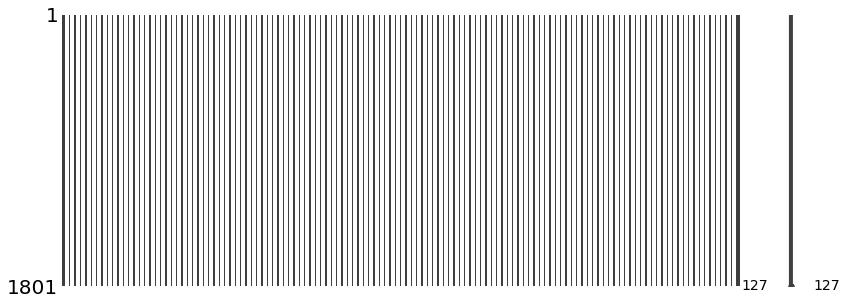

In [25]:
msno.matrix(data,figsize=(12,5))

### EDA and Visualization 

In [26]:
data[['btc_close', 'lbma_gold']].describe()

,btc_close,lbma_gold
count,1801.000000,1801.000000
mean,1837.160161,1247.667934
std,3265.618443,73.658484
min,68.500000,1049.400000
25%,291.770000,1202.650000
50%,549.600000,1256.000000
75%,1045.140000,1306.000000
max,19345.490000,1419.500000


** MARKET CAP **

/Users/rosekoh/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


[Text(0,0.5,'log(volume)'),
 Text(0.5,0,'timestamp'),
 Text(0.5,1,'volume of btc, cryptocurrency, gold in log over time')]

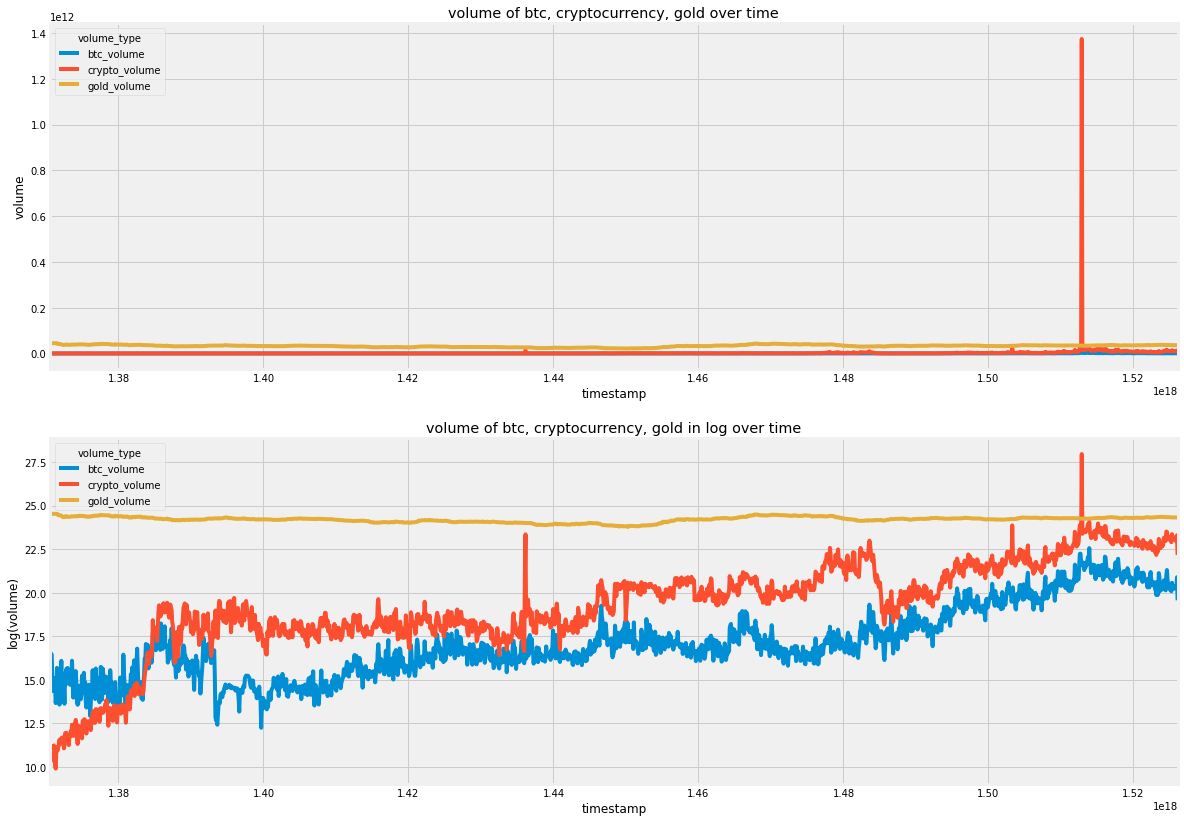

In [27]:
# bitcoin, cryptocurrency and gold volume comparison
volume = data[['date', 'btc_volume', 'crypto_volume', 'gold_volume']]
volume_index = volume.set_index('date')

# Convert the wide data to long format and plot
long = volume_index.unstack().reset_index()
long.columns = ['volume_type', 'date', 'volume']
#long = long.set_index('time')
long['log_volume'] = np.log(long['volume'])

# Plot
figure, (ax1, ax2) = plt.subplots(nrows=2, ncols=1)
figure.set_size_inches(18, 14)

sns.tsplot(data = long, time = 'date', unit = 'volume_type', condition = 'volume_type', value = 'volume', ax=ax1)
ax1.set(xlabel='timestamp', ylabel='volume', title = "volume of btc, cryptocurrency, gold over time")
sns.tsplot(data = long, time = 'date', unit = 'volume_type', condition = 'volume_type', value = 'log_volume', ax=ax2)
ax2.set(xlabel='timestamp', ylabel='log(volume)', title = "volume of btc, cryptocurrency, gold in log over time")

** VOLATILITY **

/Users/rosekoh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=7,center=False).std()
  import sys


Text(0.5,1,'Volatility -- bitcoin')

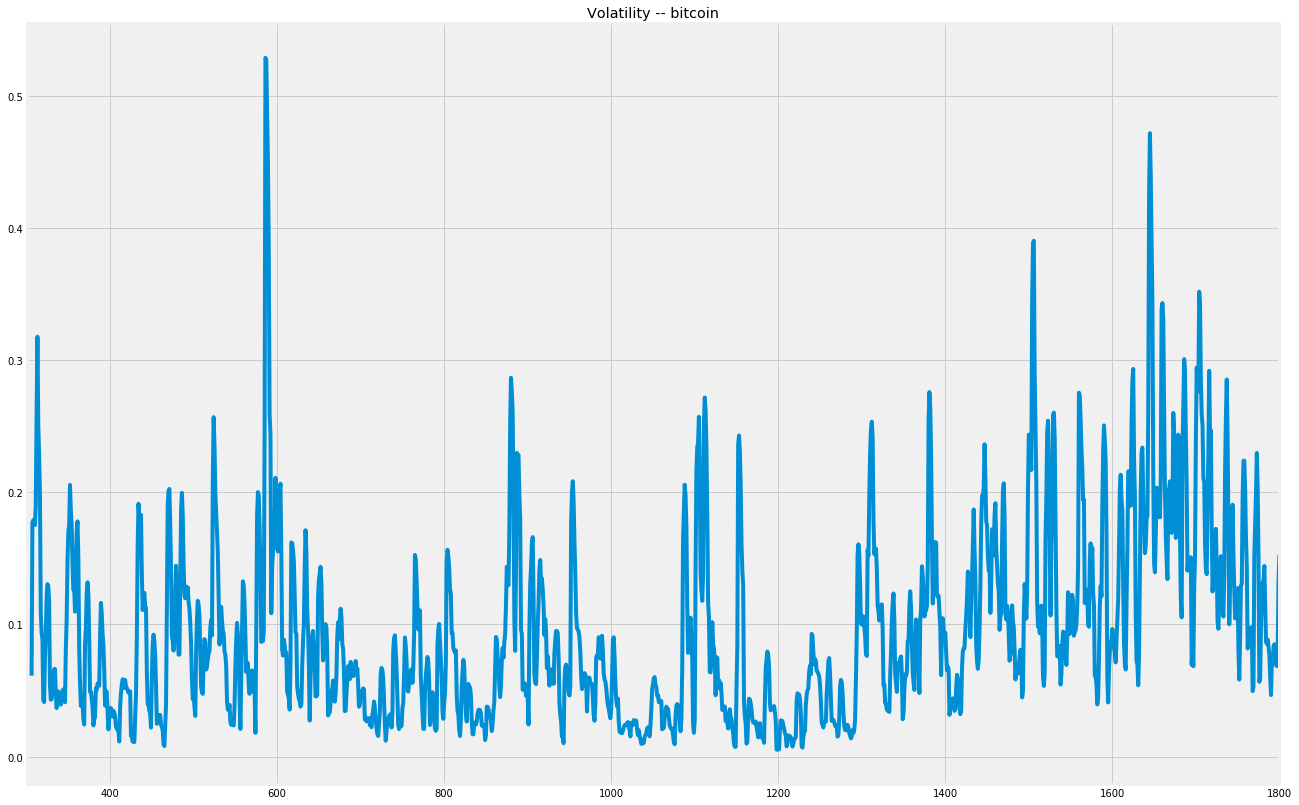

In [28]:
# gold and bitcoin price volatility (in log)

# 7 period minimum
min_periods = 7

# calculate the volatility
btc_vol = pd.stats.moments.rolling_std(np.log(data.btc_close[300:]), min_periods) * \
       np.sqrt(min_periods)

#plot
btc_vol.plot(figsize=(20, 14))
plt.title("Volatility -- bitcoin")

/Users/rosekoh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=7,center=False).std()
  """Entry point for launching an IPython kernel.


Text(0.5,1,'Volatility -- Gold')

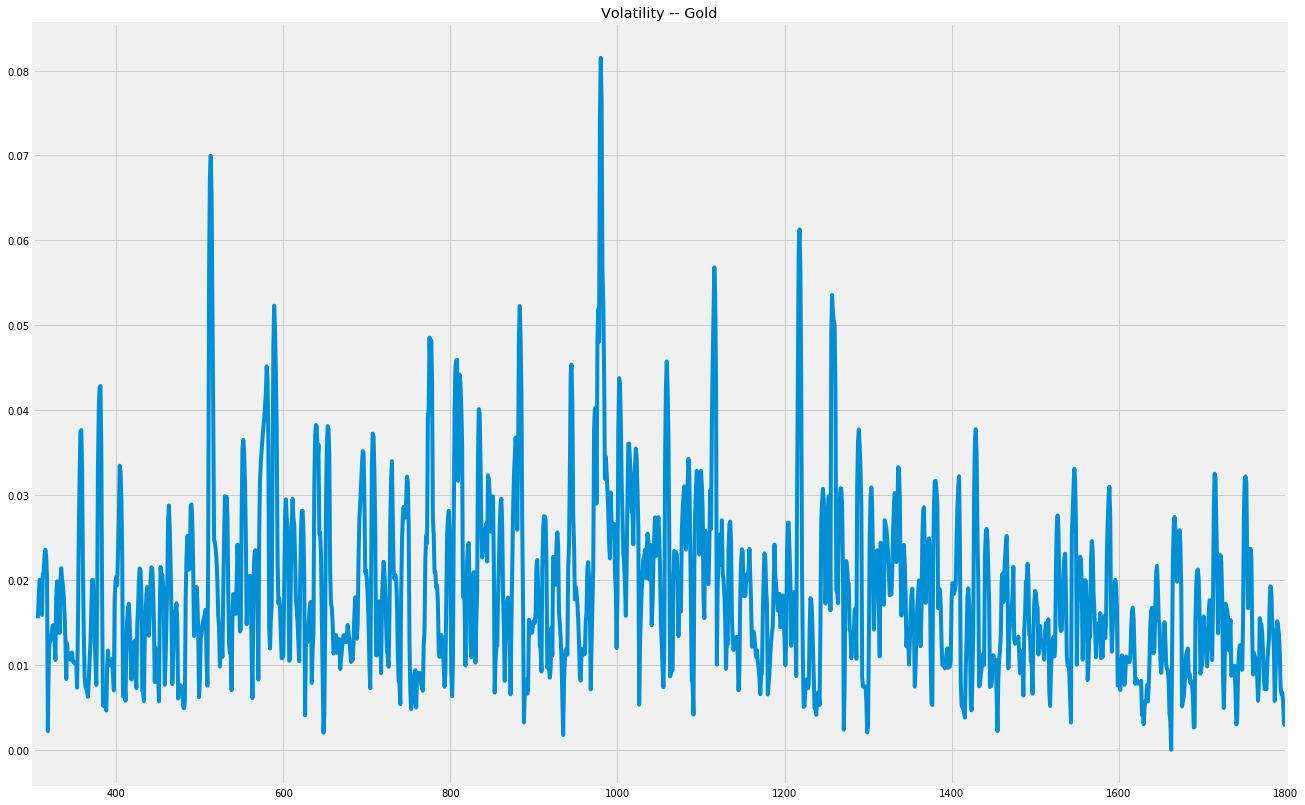

In [29]:
gold_vol = pd.stats.moments.rolling_std(np.log(data.lbma_gold[300:]), min_periods) * \
       np.sqrt(min_periods)

#plot
gold_vol.plot(figsize=(20, 14))
plt.title("Volatility -- Gold")

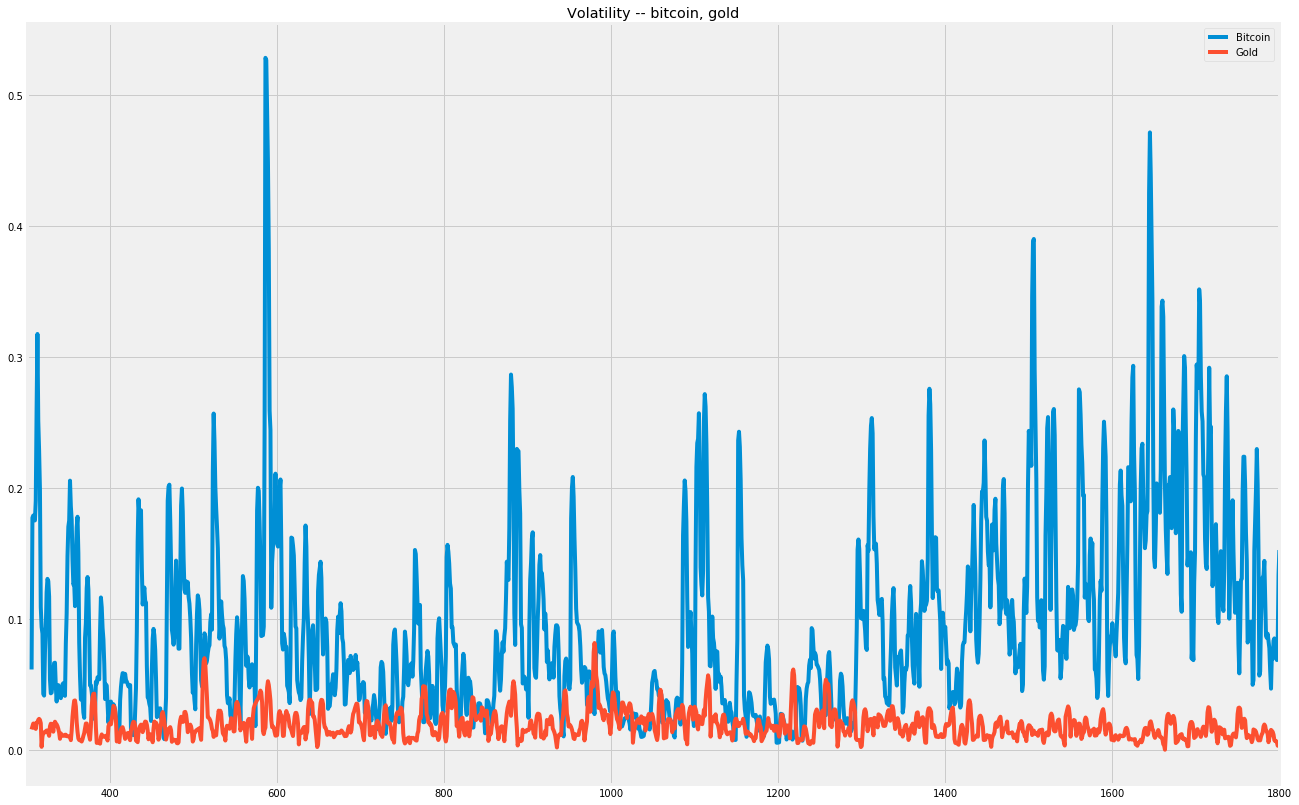

In [30]:
btc_vol.plot(figsize=(20, 14), label = 'Bitcoin')
gold_vol.plot(figsize=(20, 14), label = 'Gold')

plt.title("Volatility -- bitcoin, gold")
plt.legend()

** CORRELATION **

One common to understand how a dependent variable is influenced by features (numerical) is to find a correlation matrix between them.

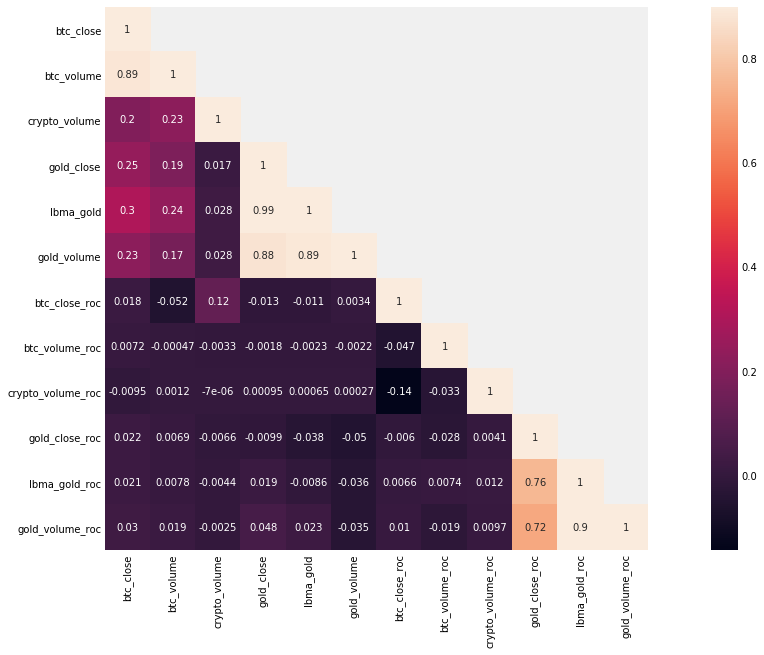

In [31]:
corr_data = data[['btc_close', 'btc_volume', 'crypto_volume', 'gold_close',\
                 'lbma_gold', 'gold_volume', 'btc_close_roc', 'btc_volume_roc',\
                 'crypto_volume_roc', 'gold_close_roc', 'lbma_gold_roc', 'gold_volume_roc']]
corr = corr_data.corr()
mask = np.array(corr)
mask[np.tril_indices_from(mask)] = False
fig, ax = plt.subplots()
fig.set_size_inches(20,10)
sns.heatmap(corr, mask=mask, vmax = .9, square = True, annot = True)

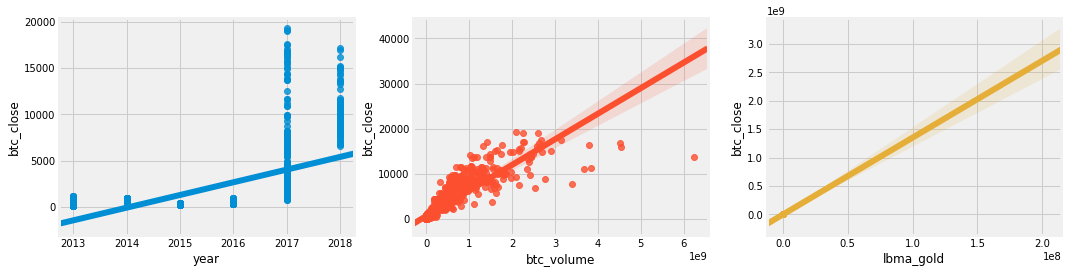

In [32]:
fig,(ax1,ax2,ax3) = plt.subplots(ncols=3)
fig.set_size_inches(16, 4)

sns.regplot(x="year", y="btc_close", data=data,ax=ax1)
sns.regplot(x="btc_volume", y="btc_close", data=data,ax=ax2)
sns.regplot(x="lbma_gold", y="btc_close", data=data,ax=ax3)

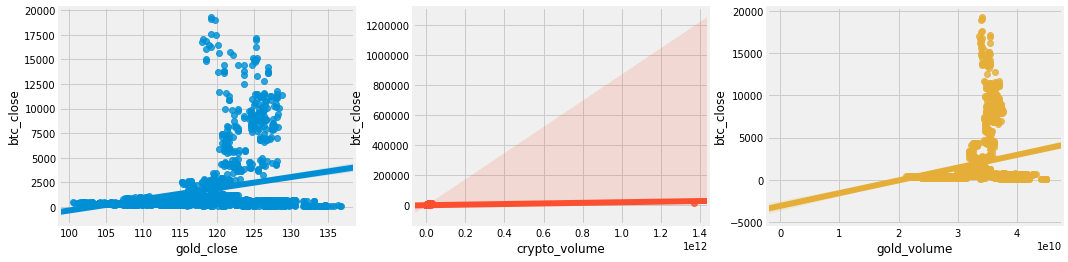

In [33]:
fig,(ax1,ax2,ax3) = plt.subplots(ncols=3)
fig.set_size_inches(16, 4)

sns.regplot(x="gold_close", y="btc_close", data=data,ax=ax1)
sns.regplot(x="crypto_volume", y="btc_close", data=data,ax=ax2)
sns.regplot(x="gold_volume", y="btc_close", data=data,ax=ax3)

** DISTRIBUTION **

((array([-3.36350738, -3.11044958, -2.9699691 , ...,  2.9699691 ,
          3.11044958,  3.36350738]),
  array([ 4.24132675,  4.25787964,  4.34380542, ...,  9.85078906,
          9.85569916,  9.87026629])),
 (1.1907788211732897, 6.5591797380870842, 0.95436203720654622))

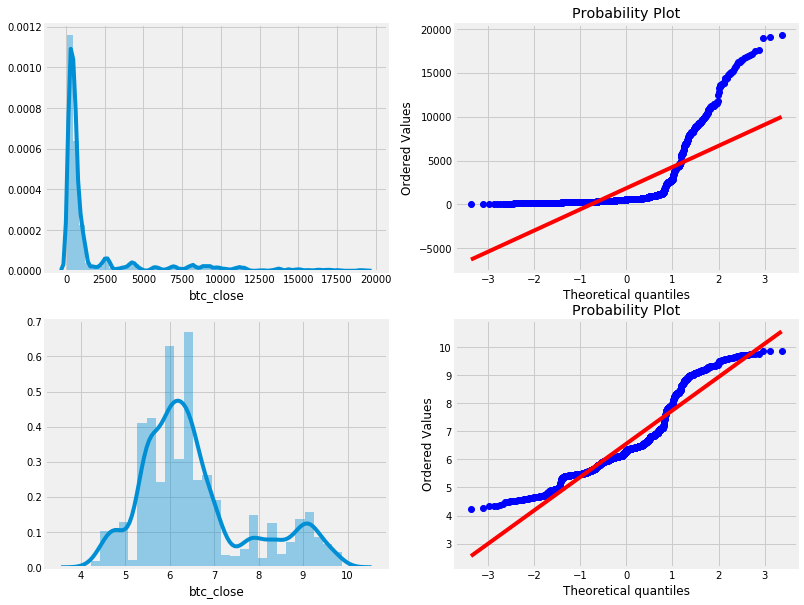

In [34]:
fig,axes = plt.subplots(ncols=2,nrows=2)
fig.set_size_inches(12, 10)
sns.distplot(data["btc_close"],ax=axes[0][0])
stats.probplot(data["btc_close"], dist='norm', fit=True, plot=axes[0][1])
sns.distplot(np.log(data["btc_close"]),ax=axes[1][0])
stats.probplot(np.log1p(data["btc_close"]), dist='norm', fit=True, plot=axes[1][1])

** SPLIT **

In [35]:
feature_names = list(data.columns[2:])

X = data[feature_names] # or X = data.drop('date', axis=1)
# X = X.drop('year-month', axis=1)

print(X.shape)
X.head(5)

(1801, 125)


,btc_volume,crypto_volume,gold_close,lbma_gold,gold_volume,year,month,week,day,dayofweek,...,day_22,day_23,day_24,day_25,day_26,day_27,day_28,day_29,day_30,day_31
0,7372031.58,51664.95,133.28,1386.00,4.485556e+10,2013,6,23,7,4,...,0,0,0,0,0,0,0,0,0,0
1,1874098.59,30641.84,133.28,1386.00,4.485556e+10,2013,6,23,8,5,...,0,0,0,0,0,0,0,0,0,0
2,14647793.51,45316.52,133.28,1386.00,4.485556e+10,2013,6,23,9,6,...,0,0,0,0,0,0,0,0,0,0
3,6786321.13,56151.74,133.96,1383.25,4.488538e+10,2013,6,24,10,0,...,0,0,0,0,0,0,0,0,0,0
4,1727992.79,72795.65,133.25,1374.25,4.459268e+10,2013,6,24,11,1,...,0,0,0,0,0,0,0,0,0,0


In [36]:
label_name = "btc_close"
y = data[label_name]

print(y.shape)
y.head(5)

(1801,)


0    111.00
1    107.89
2    100.44
3    106.35
4    109.00
Name: btc_close, dtype: float64

In [37]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

** NORMALIZATION **

** SCORER **

In [38]:
# Root mean square error
def rmse(actual, predict):
    predict = np.array(predict)
    actual = np.array(actual)
    mse = mean_squared_error(actual, predict)
    rmse = sqrt(mse)
    return rmse

# Root mean square log error
def rmsle(actual, predict):
    predict = np.array(predict)
    actual = np.array(actual)
    
    log_predict = np.log(predict + 1)
    log_actual = np.log(actual + 1)
    
    diff = log_predict - log_actual
    
    square_diff = np.square(diff)
    
    msd = square_diff.mean()
    
    score = np.sqrt(msd)
    
    return score


rmse_score = make_scorer(rmse)
rmsle_score = make_scorer(rmsle)

### OLS REGRESSION

In [67]:
import statsmodels.formula.api as sm
result = sm.ols(formula="btc_close ~ lbma_gold",
                data=data).fit()

print(result.params)
result.summary()

Intercept   -15017.899930
lbma_gold       13.509252
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              btc_close   R-squared:                       0.093
Model:                            OLS   Adj. R-squared:                  0.092
Method:                 Least Squares   F-statistic:                     184.1
Date:                Sat, 12 May 2018   Prob (F-statistic):           5.26e-40
Time:                        17:57:47   Log-Likelihood:                -17040.
No. Observations:                1801   AIC:                         3.408e+04
Df Residuals:                    1799   BIC:                         3.409e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.502e+04   1244.288    -12.069      0.000   -1.75e+04   -1.26e+04
lbma_gold     13.5093      0.996     13.570      0.000      11.557      15.462
==============================================================================
Omnibus:                      934.507   Durbin-Watson:                   0.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5503.032
Skew:                           2.456   Prob(JB):                         0.00
Kurtosis:                      10.015   Cond. No.                     2.12e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.12e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [39]:
result = sm.ols(formula="btc_close ~ btc_volume + crypto_volume + gold_close + lbma_gold + \
                 gold_volume+ year+ month+ week + day + dayofweek + \
                 btc_close_roc+ btc_volume_roc + crypto_volume_roc + \
                 gold_close_roc+ lbma_gold_roc + gold_volume_roc",
                data=data).fit() #data = train

print(result.params)
result.summary()

Intercept           -1.510249e+06
btc_volume           4.458444e-06
crypto_volume        1.176285e-10
gold_close           2.275753e+02
lbma_gold           -6.918418e+00
gold_volume         -1.462504e-07
year                 7.426431e+02
month                7.495503e+01
week                 3.814595e+00
day                  1.113473e+00
dayofweek            1.803412e+01
btc_close_roc        9.605021e-01
btc_volume_roc       2.334081e-07
crypto_volume_roc   -4.872051e-10
gold_close_roc       1.249238e+02
lbma_gold_roc        3.505542e+01
gold_volume_roc     -1.663872e-06
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              btc_close   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.847
Method:                 Least Squares   F-statistic:                     622.7
Date:                Sat, 12 May 2018   Prob (F-statistic):               0.00
Time:                        04:24:22   Log-Likelihood:                -15430.
No. Observations:                1801   AIC:                         3.089e+04
Df Residuals:                    1784   BIC:                         3.099e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          -1.51e+06    7.6e+04    -19.864      0.000   -1.66e+06   -1.36e+06
btc_volume         4.458e-06   7.83e-08     56.925      0.000     4.3e-06    4.61e-06
crypto_volume      1.176e-10   9.63e-10      0.122      0.903   -1.77e-09    2.01e-09
gold_close          227.5753     48.782      4.665      0.000     131.900     323.251
lbma_gold            -6.9184      4.707     -1.470      0.142     -16.151       2.314
gold_volume       -1.463e-07   1.54e-08     -9.513      0.000   -1.76e-07   -1.16e-07
year                742.6431     37.576     19.764      0.000     668.945     816.341
month                74.9550     36.563      2.050      0.041       3.244     146.666
week                  3.8146      8.336      0.458      0.647     -12.534      20.163
day                   1.1135      3.528      0.316      0.752      -5.806       8.033
dayofweek            18.0341     15.208      1.186      0.236     -11.793      47.861
btc_close_roc         0.9605      0.181      5.306      0.000       0.605       1.316
btc_volume_roc     2.334e-07   2.21e-07      1.055      0.292   -2.01e-07    6.67e-07
crypto_volume_roc -4.872e-10   1.35e-09     -0.360      0.719   -3.14e-09    2.17e-09
gold_close_roc      124.9238     73.051      1.710      0.087     -18.351     268.198
lbma_gold_roc        35.0554     11.068      3.167      0.002      13.348      56.763
gold_volume_roc   -1.664e-06   3.26e-07     -5.104      0.000    -2.3e-06   -1.02e-06
==============================================================================
Omnibus:                      573.339   Durbin-Watson:                   0.761
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            50067.040
Skew:                          -0.512   Prob(JB):                         0.00
Kurtosis:                      28.810   Cond. No.                     8.62e+13
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.62e+13. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [40]:
# backwards elimination
result = sm.ols(formula="btc_close ~ btc_volume  + gold_close + \
                 gold_volume+ year+ month + \
                 btc_close_roc  + \
                lbma_gold_roc + gold_volume_roc",
                data=data).fit() #data = train

print(result.params)
result.summary()

Intercept         -1.438685e+06
btc_volume         4.460746e-06
gold_close         1.566433e+02
gold_volume       -1.487737e-07
year               7.071399e+02
month              8.854873e+01
btc_close_roc      9.578147e-01
lbma_gold_roc      4.291418e+01
gold_volume_roc   -1.551909e-06
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              btc_close   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.847
Method:                 Least Squares   F-statistic:                     1244.
Date:                Sat, 12 May 2018   Prob (F-statistic):               0.00
Time:                        04:24:23   Log-Likelihood:                -15434.
No. Observations:                1801   AIC:                         3.089e+04
Df Residuals:                    1792   BIC:                         3.094e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept       -1.439e+06   6.01e+04    -23.945      0.000   -1.56e+06   -1.32e+06
btc_volume       4.461e-06   7.64e-08     58.386      0.000    4.31e-06    4.61e-06
gold_close        156.6433     10.913     14.354      0.000     135.240     178.046
gold_volume     -1.488e-07   1.52e-08     -9.795      0.000   -1.79e-07   -1.19e-07
year              707.1399     29.584     23.903      0.000     649.118     765.162
month              88.5487     10.383      8.528      0.000      68.185     108.913
btc_close_roc       0.9578      0.177      5.411      0.000       0.611       1.305
lbma_gold_roc      42.9142     10.242      4.190      0.000      22.826      63.002
gold_volume_roc -1.552e-06   3.22e-07     -4.820      0.000   -2.18e-06    -9.2e-07
==============================================================================
Omnibus:                      565.309   Durbin-Watson:                   0.750
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            49512.904
Skew:                          -0.483   Prob(JB):                         0.00
Kurtosis:                      28.669   Cond. No.                     6.59e+13
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.59e+13. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Linear regression

In [41]:
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Initialize Linear regression model
linear_model = LinearRegression()


# Train the model
yLabelsLog = np.log1p(y_train)
linear_model.fit(X = X_train, y = yLabelsLog)

# Make predictions
%time preds = linear_model.predict(X = X_train)
print ("Linear Regression RMSLE Score: ",rmsle(np.exp(yLabelsLog),np.exp(preds)))


# Train the model
linear_model.fit(X = X_train, y = y_train)

# Make predictions
%time preds = linear_model.predict(X = X_train)
print ("Linear Regression RMSE Score: ",rmse(y_train, preds))

# Cross validation
%time lr_rmse = cross_val_score(linear_model, X_train, y_train , cv = 20, scoring = rmse_score).mean()
print("Linear Regression RMSE Score = {0:.5f}".format(lr_rmse))

CPU times: user 3.02 ms, sys: 233 µs, total: 3.26 ms
Wall time: 844 µs
Linear Regression RMSLE Score:  0.336911299108
CPU times: user 3.42 ms, sys: 533 µs, total: 3.95 ms
Wall time: 939 µs
Linear Regression RMSE Score:  880.2002846607078
CPU times: user 615 ms, sys: 12.5 ms, total: 628 ms
Wall time: 163 ms
Linear Regression RMSE Score = 981.05011


### Regularization - Ridge

CPU times: user 1.64 ms, sys: 74 µs, total: 1.72 ms
Wall time: 449 µs
{'alpha': 10, 'max_iter': 3000}
RMSLE Value For Ridge Regression:  0.338934908049


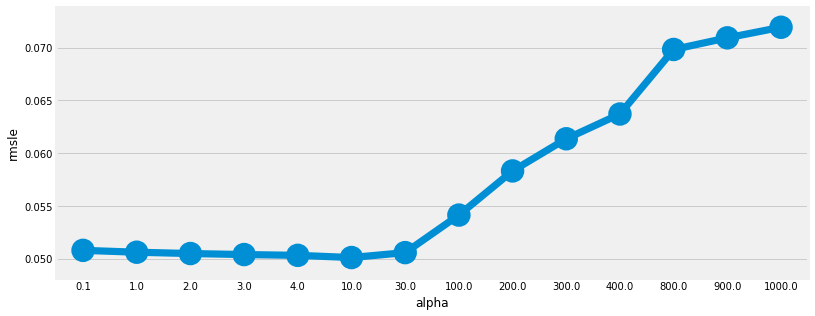

In [42]:
ridge_m_ = Ridge()
ridge_params_ = { 'max_iter':[3000],'alpha':[0.1, 1, 2, 3, 4, 10, 30,100,200,300,400,800,900,1000]}
rmsle_scorer = metrics.make_scorer(rmsle, greater_is_better=False)
grid_ridge_m = GridSearchCV( ridge_m_,
                          ridge_params_,
                          scoring = rmsle_scorer,
                          cv=5)
yLabelsLog = np.log1p(y_train)
grid_ridge_m.fit( X_train, yLabelsLog )
%time preds = grid_ridge_m.predict(X= X_train)
print (grid_ridge_m.best_params_)
print ("RMSLE Value For Ridge Regression: ",rmsle(np.exp(yLabelsLog),np.exp(preds)))

fig,ax= plt.subplots()
fig.set_size_inches(12,5)
df = pd.DataFrame(grid_ridge_m.grid_scores_)
df["alpha"] = df["parameters"].apply(lambda x:x["alpha"])
df["rmsle"] = df["mean_validation_score"].apply(lambda x:-x)
sns.pointplot(data=df,x="alpha",y="rmsle",ax=ax)

CPU times: user 1.94 ms, sys: 74 µs, total: 2.01 ms
Wall time: 500 µs
{'alpha': 1000, 'max_iter': 3000}
RMSE Value For Ridge Regression:  1014.3100896211686
CPU times: user 28 s, sys: 693 ms, total: 28.7 s
Wall time: 8.88 s
Ridge Regression RMSE Score = 1043.61194


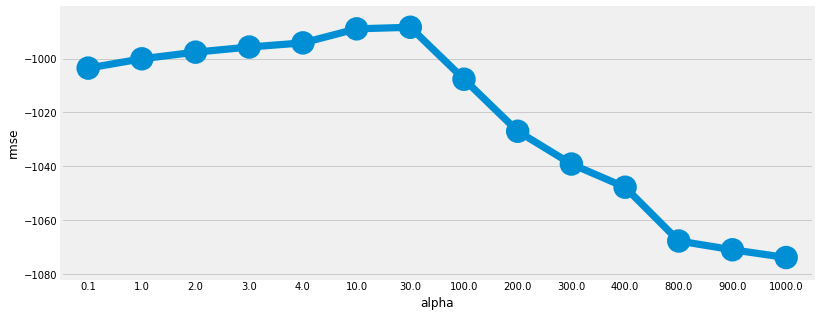

In [43]:
grid_ridge_m = GridSearchCV( ridge_m_,
                          ridge_params_,
                          scoring = rmse_score,
                          cv=5)

grid_ridge_m.fit( X_train, y_train )
%time preds = grid_ridge_m.predict(X= X_train)
print (grid_ridge_m.best_params_)
print ("RMSE Value For Ridge Regression: ",rmse(y_train, preds))

fig,ax= plt.subplots()
fig.set_size_inches(12,5)
df = pd.DataFrame(grid_ridge_m.grid_scores_)
df["alpha"] = df["parameters"].apply(lambda x:x["alpha"])
df["rmse"] = df["mean_validation_score"].apply(lambda x:-x)
sns.pointplot(data=df,x="alpha",y="rmse",ax=ax)

# Cross validation
%time ridge_score = cross_val_score(grid_ridge_m, X_train, y_train , cv = 20, scoring = rmse_score).mean()
print("Ridge Regression RMSE Score = {0:.5f}".format(ridge_score))

### Regularization - Lasso

/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


{'alpha': 0.0025000000000000001, 'max_iter': 3000}
RMSLE Value For Lasso Regression:  0.345420280023


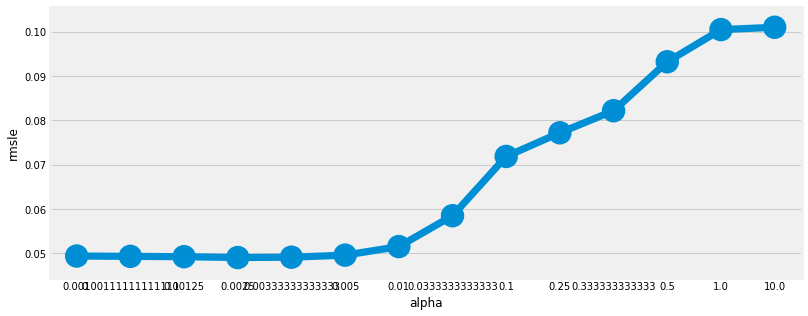

In [44]:
lasso_m_ = Lasso()

alpha  = 1/np.array([0.1, 1, 2, 3, 4, 10, 30,100,200,300,400,800,900,1000])
lasso_params_ = { 'max_iter':[3000],'alpha':alpha}

grid_lasso_m = GridSearchCV( lasso_m_,lasso_params_,scoring = rmsle_scorer,cv=5)
yLabelsLog = np.log1p(y_train)
grid_lasso_m.fit( X_train, yLabelsLog )
preds = grid_lasso_m.predict(X= X_train)
print (grid_lasso_m.best_params_)
print ("RMSLE Value For Lasso Regression: ",rmsle(np.exp(yLabelsLog),np.exp(preds)))

fig,ax= plt.subplots()
fig.set_size_inches(12,5)
df = pd.DataFrame(grid_lasso_m.grid_scores_)
df["alpha"] = df["parameters"].apply(lambda x:x["alpha"])
df["rmsle"] = df["mean_validation_score"].apply(lambda x:-x)
sns.pointplot(data=df,x="alpha",y="rmsle",ax=ax)

/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective di

/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective di

CPU times: user 1.1 ms, sys: 616 µs, total: 1.71 ms
Wall time: 1.11 ms
{'alpha': 0.001, 'max_iter': 3000}
RMSE Value For Lasso Regression:  880.2003215325853


/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective di

/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective di

/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective di

/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective di

/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective di

/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective di

/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective di

/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective di

/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective di

/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective di

/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective di

/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective di

/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective di

/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective di

/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective di

/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective di

/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective di

/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective di

/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective di

/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective di

/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective di

/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective di

/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective di

/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective di

/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective di

/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective di

/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective di

/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective di

/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective di

/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective di

/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective di

/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective di

/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective di

/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective di

/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective di

/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective di

/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective di

/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective di

CPU times: user 5min 59s, sys: 2.13 s, total: 6min 2s
Wall time: 6min
Lasso Regression RMSE Score = 978.99416


/Users/rosekoh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


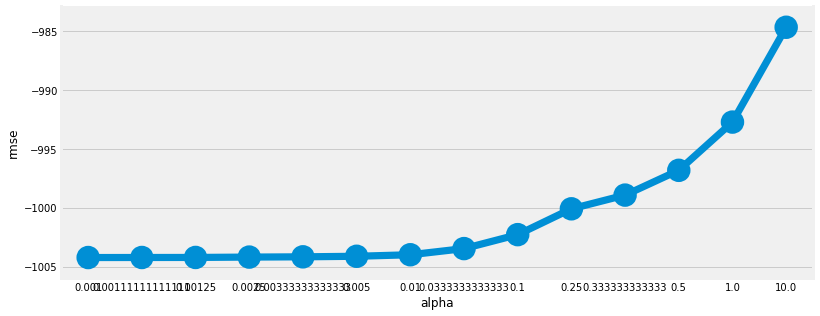

In [45]:
grid_lasso_m = GridSearchCV( lasso_m_,lasso_params_,scoring = rmse_score,cv=5)

grid_lasso_m.fit( X_train, y_train )
%time preds = grid_lasso_m.predict(X= X_train)
print (grid_lasso_m.best_params_)
print ("RMSE Value For Lasso Regression: ",rmse(y_train, preds))


fig,ax= plt.subplots()
fig.set_size_inches(12,5)
df = pd.DataFrame(grid_lasso_m.grid_scores_)
df["alpha"] = df["parameters"].apply(lambda x:x["alpha"])
df["rmse"] = df["mean_validation_score"].apply(lambda x:-x)
sns.pointplot(data=df,x="alpha",y="rmse",ax=ax)


# Cross validation
%time lasso_score = cross_val_score(grid_lasso_m, X_train, y_train , cv = 20, scoring = rmse_score).mean()
print("Lasso Regression RMSE Score = {0:.5f}".format(lasso_score))

### Ensemble - Random Forest

In [46]:
rfModel = RandomForestRegressor(n_estimators=100)
yLabelsLog = np.log1p(y_train)
rfModel.fit(X_train,yLabelsLog)
%time preds = rfModel.predict(X= X_train)
print("RMSLE Value For Random Forest: ",rmsle(np.exp(yLabelsLog),np.exp(preds)))

CPU times: user 22.1 ms, sys: 26 µs, total: 22.1 ms
Wall time: 22.1 ms
RMSLE Value For Random Forest:  0.0492671751836


In [47]:
rfModel.fit(X_train,y_train)
%time preds = rfModel.predict(X= X_train)
print("RMSE Value For Random Forest: ",rmse(y_train, preds))

# Cross validation
%time rf_score = cross_val_score(rfModel, X_train, y_train , cv = 20, scoring = rmse_score).mean()
print("Lasso Regression RMSE Score = {0:.5f}".format(rf_score))

CPU times: user 22.9 ms, sys: 44 µs, total: 23 ms
Wall time: 23 ms
RMSE Value For Random Forest:  169.00374593915663
CPU times: user 34.3 s, sys: 56.5 ms, total: 34.3 s
Wall time: 34.4 s
Lasso Regression RMSE Score = 461.79374


### Ensemble - Gradient boosting regression

In [48]:
gbm = GradientBoostingRegressor(n_estimators=4000,alpha=0.01);
yLabelsLog = np.log1p(y_train)
gbm.fit(X_train,yLabelsLog)
%time preds = gbm.predict(X= X_train)
print ("RMSLE Value For Gradient Boost: ",rmsle(np.exp(yLabelsLog),np.exp(preds)))

CPU times: user 67 ms, sys: 131 µs, total: 67.1 ms
Wall time: 67.2 ms
RMSLE Value For Gradient Boost:  0.000565325131274


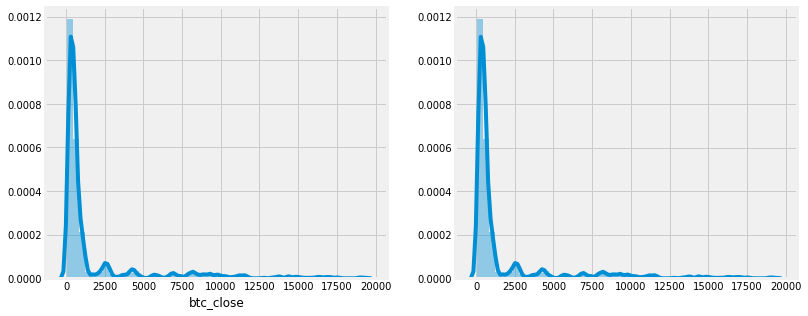

In [49]:
predsTest = gbm.predict(X= X_train)
fig,(ax1,ax2)= plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sns.distplot(y_train,ax=ax1,bins=50)
sns.distplot(np.exp(predsTest),ax=ax2,bins=50)

In [50]:
gbm.fit(X_train,y_train)
%time preds = gbm.predict(X= X_train)
print ("RMSE Value For Gradient Boost: ",rmse(y_train, preds))

# Cross validation
%time gbm_score = cross_val_score(gbm, X_train, y_train , cv = 20, scoring = rmse_score).mean()
print("Gradient Boost RMSE Score = {0:.5f}".format(gbm_score))

CPU times: user 66.7 ms, sys: 86 µs, total: 66.7 ms
Wall time: 66.7 ms
RMSE Value For Gradient Boost:  0.5275079052614802
CPU times: user 4min 42s, sys: 461 ms, total: 4min 43s
Wall time: 4min 43s
Gradient Boost RMSE Score = 449.59275


### XGBoost

In [51]:
xgb_model = xgb.XGBClassifier(n_estimators=15,
                          nthread=-1)

%time xgb_score = cross_val_score(xgb_model, X_train, y_train, scoring=rmsle_score, cv=5).mean()

print("XGBoost Score = {0:.5f}".format(xgb_score))

#1.34262

CPU times: user 8h 44min 14s, sys: 31.2 s, total: 8h 44min 45s
Wall time: 8h 45min 28s
XGBoost Score = 1.40248


In [52]:
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=15,
       n_jobs=1, nthread=-1, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [53]:
xgb_predictions = xgb_model.predict_proba(X_test)

In [ ]:
%time preds = xgb_model.predict(X_train)
print ("RMSE Value For XGBoost: ",rmse(y_train, preds))

# Cross validation
%time xgb_rmse_score = cross_val_score(gbm, X_train, y_train , cv = 20, scoring = rmse_score).mean()
print("XGBoost RMSE Score = {0:.5f}".format(xgb_rmse_score))

---

## 4. Conclusion and future development

** Hypothesis evaluation **

<u>Does bitcoin price and gold price have any correlation? What is the relationship between the price of BTC and Gold?</u>

As we have seen in the regression plot above at the correlation analysis, `BTC daily close price` and `lbma gold price` appears to have strong linear relationship. From the OLS regression results, 

* Adj. R-squared: 0.092
* Intercept: -15017.8999
* p-value: 0.000

And the regression equation is 

<i> * Estimated Bitcoin price = -15017.8999 + 13.5093 * lbma_gold_price </i>

The intercept -15017.8999 means that the expected bitcoin price when lbma gold price is 0, is -15017. It means without gold, BTC has no value. This doesn't seem to make sense and the regression will only return meaningful value when the inputs are in specific range. 

The Adj. R-squred means that 9.2% of the variability in Bitcoin price is explained by lbma Gold price.

Multivariate regression analysis returned better results with Adj. R-squared at 84.7%. This means the chosen variables explains 84.7% of the bitcoin price.

After examining the regression results, backwards elimination approach was implemented, only to return the same Adj. R-squared value.

** Feature engineering **

The new columns such as dates, rate of change are added. As this is time-series data yet the objective being to predict using multiple variables to predict BTC price, parsing the dates as variable was considered. Though The dates are regarded as int value that would impact regression model which was why dummy variables method is implemented -- this could potentially draw better results in the machine learning models.


** Machine learning models and scores (RMSLE, RMSE) ** 


- OLS(ordinary least squares) Regression
     - Backwards elimination
- Linear regression model
- Regularization models - Ridge, Lasso
- Ensemble models - Random forest, Gradient boosting regression
- XGboost

In [94]:
# As the seed was not set, the values may differ if reproduced.
# XGBoost calculation for RMSE was time consuming to include in this notebook.

score_table = pd.DataFrame({"Model":["Linear Regression", "Regularization- Ridge", \
                            "Regularization-Lasso", "Ensemble-Random Forest", \
                            "Ensemble-Gradient boosting regression", "XGBoost"],\
                   "RMSLE":[0.3369,0.3389,0.3454,0.0492,0.0005, 1.4024], \
                   "RMSE":[880.2002,1014.3100,880.2003,169.0037,0.5275,'NA'], \
                   "RMSE(CV)": [981.0501,1043.6119,978.9941,461.7937,449.5927,'NA']
                  })
score_table

,Model,RMSE,RMSE(CV),RMSLE
0,Linear Regression,880.2,981.05,0.3369
1,Regularization- Ridge,1014.31,1043.61,0.3389
2,Regularization-Lasso,880.2,978.994,0.3454
3,Ensemble-Random Forest,169.004,461.794,0.0492
4,Ensemble-Gradient boosting regression,0.5275,449.593,0.0005
5,XGBoost,NA,NA,1.4024


** Scorer **

Root Mean Squared Error (RMSE) and Root Mean Squared Logarithmic Error (RMSLE) both are the techniques to find out the difference between the values predicted by your machine learning model and the actual values.

* RMSE

Mean Squared Error incorporates both the variance and the bias of the predictor. RMSE is the square root of MSE. In case of unbiased estimator, RMSE is just the square root of variance, which is actually Standard Deviation.

* RMSLE

For RMSLE, the log of the predictions and actual values are taken. It changes the variance that we measure.

<i>log(pi+1)−log(ai+1) = log((pi+1)/(ai+1))</i>

RMSLE can be used when you do not want to penalize huge differenes when both values are big numbers. This also can be used when you want to penalize under estimates more than over estimates.

Case a) : 
Pi = 600, Ai = 1000
RMSE = 400, RMSLE = 0.5108

Case b) : 
Pi = 1400, Ai = 1000
RMSE = 400, RMSLE = 0.3365

As above case a,b shows, RMSE treats them equally whereas RMSLE penalized the under estimates more than over estimates.

According to our score table, the best model to predict BTC price would be Ensemble - Gradient boosting regression model.

** Possible future research **

- Residual analysis
- Anova analysis
- Hyperparameter tuning